In [18]:
import sys
from pathlib import Path

# Add parent directory to path so we can import src module
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Import custom modules from src directory for better organization
from src.preprocessing import (
    load_data,
    missing_value_handling,
    labels_encoding,
    clean_text,
    preprocess_data,
    get_text_stats,
    data_split,
    get_class_distribution,
    get_sample_message
)

from src.modeling import (
    vectorize_text,
    train_baseline_model,
    train_logistic_regression,
    train_decision_tree,
    save_model,
    get_feature_importance
)

from src.evaluation import (
    evaluate_model,
    print_evaluation_report,
    plot_confusion_matrix,
    analyze_errors,
    print_error_analysis,
    plot_roc_curve,
    compare_models,
    save_metrics_to_csv
)

# Set random seed
np.random.seed(42)
# Setup paths
figures_path = Path('../results/figures')

In [3]:
# Load Data & Basic check

df = pd.read_csv('../data/processed/spam_with_features.csv')

print(f"Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

print("\nColumn names:")
print(df.columns.tolist())

print("\nFirst few rows:")
print(df.head())

# Check data types
print("\nData types:")
print(df.dtypes)

Shape: (5572, 25)
Rows: 5,572
Columns: 25

Column names:
['label', 'message', 'message_length', 'word_count', 'avg_word_length', 'num_exclamation', 'num_question', 'num_capitals', 'capital_ratio', 'has_numbers', 'has_currency', 'has_phone', 'has_url', 'urgency_count', 'money_count', 'action_count', 'has_time_words', 'starts_with_free', 'congratulations', 'youve_won', 'click_here', 'call_now', 'txt_to', 'reply_to', 'label_numeric']

First few rows:
  label                                            message  message_length  \
0   ham  Go until jurong point, crazy.. Available only ...             111   
1   ham                      Ok lar... Joking wif u oni...              29   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...             155   
3   ham  U dun say so early hor... U c already then say...              49   
4   ham  Nah I don't think he goes to usf, he lives aro...              61   

   word_count  avg_word_length  num_exclamation  num_question  num_capitals  \


In [4]:
# Data Prep & Preprocessing

# Check for missing values
missing = df.isnull().sum()
print("\nMissing values:")
print(missing[missing > 0])

if missing.sum() > 0:
    df = missing_value_handling(df)
    print("✓ Missing values handled")

# Ensure we have required columns
required_cols = ['label', 'message', 'cleaned_message', 'label_numeric']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"\n⚠ Missing required columns: {missing_cols}")
    
    # Create cleaned_message if it doesn't exist
    if 'cleaned_message' not in df.columns:
        print("Creating cleaned_message column...")
        df = preprocess_data(df, text_col='message')
        print("✓ Text cleaned")
    
    # Create label_numeric if it doesn't exist
    if 'label_numeric' not in df.columns:
        print("Creating label_numeric column...")
        df['label_numeric'] = df['label'].map({'ham': 0, 'spam': 1})
        print("✓ Labels encoded")
else:
    print("✓ All required columns present")

# Verify class distribution
class_dist = df['label'].value_counts()
print("\nClass distribution:")
print(class_dist)
print(f"\nClass balance:")
for label, count in class_dist.items():
    pct = count / len(df) * 100
    print(f"  {label}: {count:,} ({pct:.1f}%)")


Missing values:
Series([], dtype: int64)

⚠ Missing required columns: ['cleaned_message']
Creating cleaned_message column...
✓ Text cleaned

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Class balance:
  ham: 4,825 (86.6%)
  spam: 747 (13.4%)


In [5]:
# Feature Selection 

# Features from the list I'm considering based on EDA - 3 Tiers - must have, strong, and moderate
custom_features = [
    'has_phone',      
    'has_numbers',     
    'money_count',      
    'action_count',    
    'has_currency',    
    'message_length',   
    'has_url',          
    'word_count',       
]

print("\nCustom features selected (from EDA):")
for i, feat in enumerate(custom_features, 1):
    print(f"  {i}. {feat}")

# Verify all features exist
available_features = [f for f in custom_features if f in df.columns]
missing_features = [f for f in custom_features if f not in df.columns]

print(f"\n Available: {len(available_features)}/{len(custom_features)}")
if missing_features:
    print(f"Missing: {missing_features}")
    custom_features = available_features



Custom features selected (from EDA):
  1. has_phone
  2. has_numbers
  3. money_count
  4. action_count
  5. has_currency
  6. message_length
  7. has_url
  8. word_count

 Available: 8/8


In [6]:
# Train - Test Split

train_df, test_df = data_split(df, test_size=0.2, random_state=42)

print(f"\nTrain set: {len(train_df):,} samples")
print(f"Test set:  {len(test_df):,} samples")

# Verify stratification worked
print("\nTrain set class distribution:")
print(train_df['label'].value_counts(normalize=True) * 100)

print("\nTest set class distribution:")
print(test_df['label'].value_counts(normalize=True) * 100)

# Extract features and labels
X_train_text = train_df['cleaned_message']
X_test_text = test_df['cleaned_message']

y_train = train_df['label_numeric']
y_test = test_df['label_numeric']

# Extract custom features
X_train_custom = train_df[custom_features].values
X_test_custom = test_df[custom_features].values

print(f"\n✓ Data split complete")
print(f"Custom features shape: {X_train_custom.shape}")


Train set: 4,457 samples
Test set:  1,115 samples

Train set class distribution:
label
ham     86.60534
spam    13.39466
Name: proportion, dtype: float64

Test set class distribution:
label
ham     86.547085
spam    13.452915
Name: proportion, dtype: float64

✓ Data split complete
Custom features shape: (4457, 8)


In [7]:
# Text Vectorization

X_train_tfidf, X_test_tfidf, vectorizer = vectorize_text(
    X_train_text,
    X_test_text,
    vectorizer_type='tfidf',
    max_features=5000,
    ngram_range=(1, 1)  # unigrams only
)

print(f"\nTF-IDF vectorization complete:")
print(f"  Training shape: {X_train_tfidf.shape}")
print(f"  Test shape:     {X_test_tfidf.shape}")
print(f"  Vocabulary size: {len(vectorizer.get_feature_names_out())}")

# Save vectorizer for future use
save_model(vectorizer, '../models/tfidf_vectorizer.pkl')



TF-IDF vectorization complete:
  Training shape: (4457, 5000)
  Test shape:     (1115, 5000)
  Vocabulary size: 5000
Model saved to ../models/tfidf_vectorizer.pkl


In [8]:
# Combining TF-IDF features with custom features

# Convert custom features to float to ensure compatibility with sparse matrices
X_train_custom_float = X_train_custom.astype(float)
X_test_custom_float = X_test_custom.astype(float)

X_train_combined = hstack([X_train_tfidf, X_train_custom_float])
X_test_combined = hstack([X_test_tfidf, X_test_custom_float])

print(f"\nCombined feature matrix:")
print(f"  TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"  Custom features: {X_train_custom_float.shape[1]}")
print(f"  Total features:  {X_train_combined.shape[1]}")
print(f"\nTraining shape: {X_train_combined.shape}")
print(f"Test shape:     {X_test_combined.shape}")


Combined feature matrix:
  TF-IDF features: 5000
  Custom features: 8
  Total features:  5008

Training shape: (4457, 5008)
Test shape:     (1115, 5008)



Evaluation Report: Baseline Model (Majority Class)

Accuracy:  0.8655
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000

------------------------------------------------------------
Classification Report:
------------------------------------------------------------

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       0.00      0.00      0.00       150

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115

Confusion matrix saved to ../results/figures/confusion_matrix_baseline.png


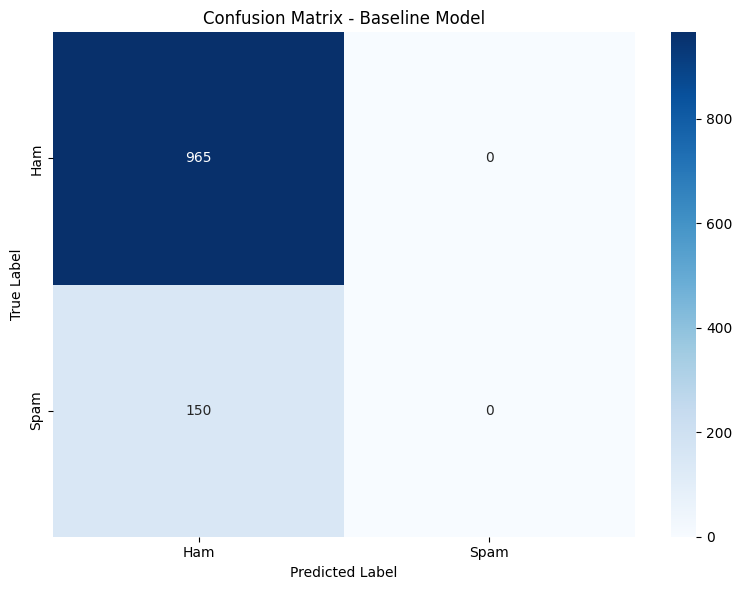


Baseline Interpretation:
The baseline always predicts 'ham' (majority class).This gives high accuracy due to class imbalance, but completely fails to detect any spam (recall = 0)


In [9]:
# Baseline Model

baseline = train_baseline_model(X_train_combined, y_train)

# Predictions
y_pred_baseline = baseline.predict(X_test_combined)

# Evaluation
print_evaluation_report(y_test, y_pred_baseline, "Baseline Model (Majority Class)")

# Confusion matrix
fig, ax = plot_confusion_matrix(
    y_test,
    y_pred_baseline,
    "Baseline Model",
    save_path='../results/figures/confusion_matrix_baseline.png'
)
plt.show()

# Store metrics
baseline_metrics = evaluate_model(y_test, y_pred_baseline, "Baseline")


print("\nBaseline Interpretation:")
print("The baseline always predicts 'ham' (majority class).This gives high accuracy due to class imbalance, but completely fails to detect any spam (recall = 0)")



Evaluation Report: Logistic Regression

Accuracy:  0.9830
Precision: 0.9925
Recall:    0.8800
F1 Score:  0.9329

------------------------------------------------------------
Classification Report:
------------------------------------------------------------

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.99      0.88      0.93       150

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Confusion matrix saved to ../results/figures/confusion_matrix_logistic.png


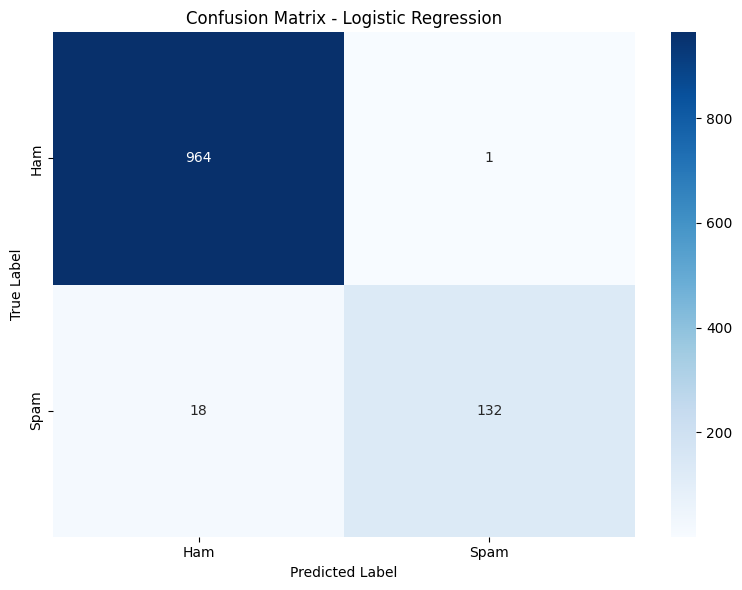

ROC curve saved to ../results/figures/roc_curve_logistic.png


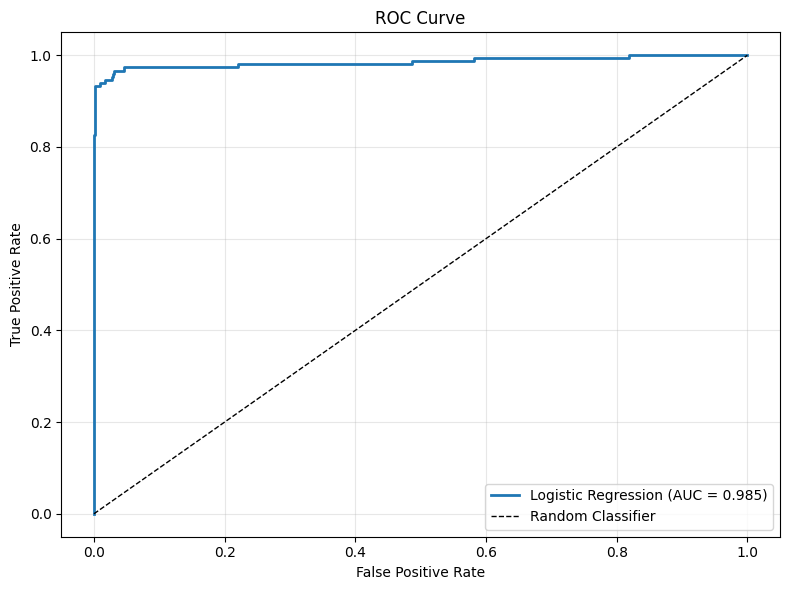


 AUC Score: 0.9847
Model saved to ../models/logistic_regression.pkl


In [10]:
# Logistic Regression Model

# Logistic Regression Training
lr_model = train_logistic_regression(
    X_train_combined,
    y_train,
    max_iter=1000,
    random_state=42
)

# Prediction
y_pred_lr = lr_model.predict(X_test_combined)
y_pred_proba_lr = lr_model.predict_proba(X_test_combined)[:, 1]

# Evaluation
print_evaluation_report(y_test, y_pred_lr, "Logistic Regression")

# Confusion matrix
fig, ax = plot_confusion_matrix(
    y_test,
    y_pred_lr,
    "Logistic Regression",
    save_path='../results/figures/confusion_matrix_logistic.png'
)
plt.show()

# ROC Curve
fig, ax, auc_score = plot_roc_curve(
    y_test,
    y_pred_proba_lr,
    "Logistic Regression",
    save_path='../results/figures/roc_curve_logistic.png'
)
plt.show()

print(f"\n AUC Score: {auc_score:.4f}")

# Store metrics
lr_metrics = evaluate_model(y_test, y_pred_lr, "Logistic Regression")
lr_metrics['auc'] = auc_score

# Save model
save_model(lr_model, '../models/logistic_regression.pkl')


Evaluation Report: Decision Tree

Accuracy:  0.9785
Precision: 0.9922
Recall:    0.8467
F1 Score:  0.9137

------------------------------------------------------------
Classification Report:
------------------------------------------------------------

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.99      0.85      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Confusion matrix saved to ../results/figures/confusion_matrix_decision_tree.png


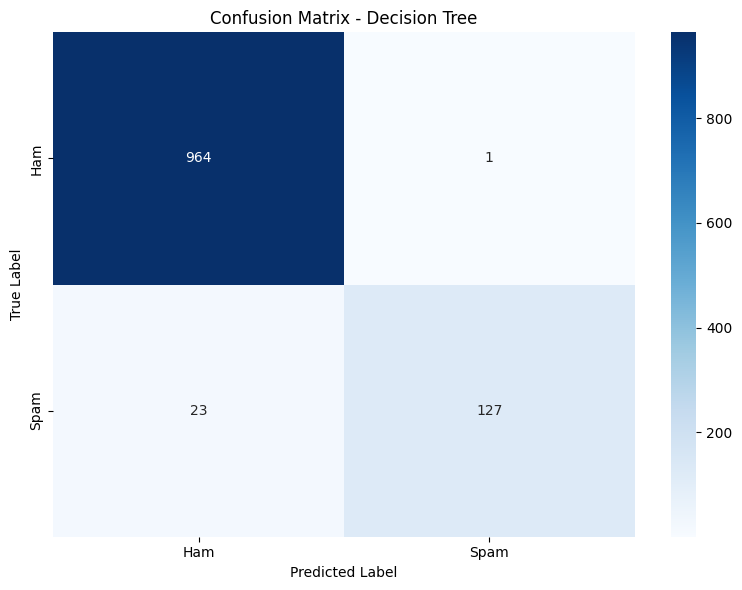

ROC curve saved to ../results/figures/roc_curve_decision_tree.png


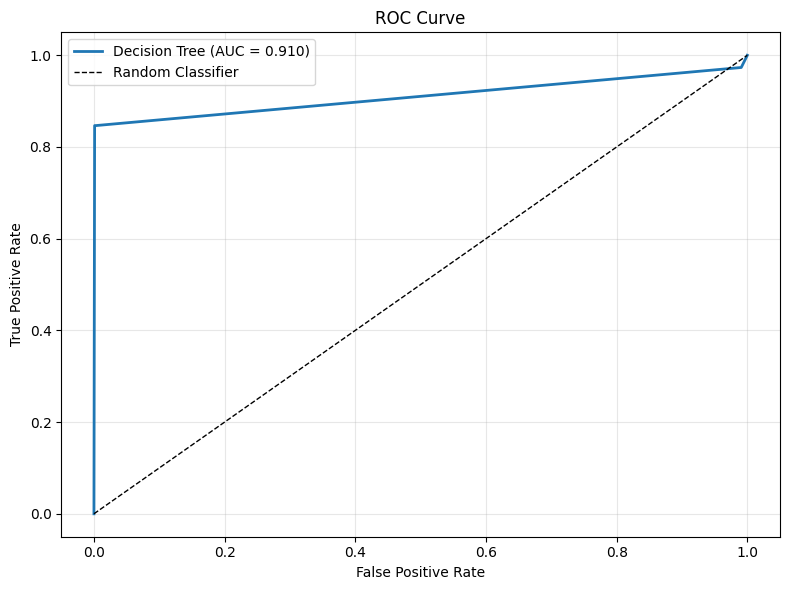


 AUC Score: 0.9101
Model saved to ../models/decision_tree.pkl


In [11]:
# Deccision Tree

# Decision Tree Training
dt_model = train_decision_tree(
    X_train_combined,
    y_train,
    max_depth=10,
    random_state=42
)

# Predictions
y_pred_dt = dt_model.predict(X_test_combined)
y_pred_proba_dt = dt_model.predict_proba(X_test_combined)[:, 1]

# Evaluation
print_evaluation_report(y_test, y_pred_dt, "Decision Tree")

# Confusion matrix
fig, ax = plot_confusion_matrix(
    y_test,
    y_pred_dt,
    "Decision Tree",
    save_path='../results/figures/confusion_matrix_decision_tree.png'
)
plt.show()

# ROC Curve
fig, ax, auc_score_dt = plot_roc_curve(
    y_test,
    y_pred_proba_dt,
    "Decision Tree",
    save_path='../results/figures/roc_curve_decision_tree.png'
)
plt.show()

print(f"\n AUC Score: {auc_score_dt:.4f}")

# Store metrics
dt_metrics = evaluate_model(y_test, y_pred_dt, "Decision Tree")
dt_metrics['auc'] = auc_score_dt

# Save model
save_model(dt_model, '../models/decision_tree.pkl')


Model Performance Comparison:
         model_name  accuracy  precision  recall  f1_score    auc
           Baseline    0.8655     0.0000  0.0000    0.0000    NaN
Logistic Regression    0.9830     0.9925  0.8800    0.9329 0.9847
      Decision Tree    0.9785     0.9922  0.8467    0.9137 0.9101

 Comparison saved to: results/metrics/model_comparison.csv


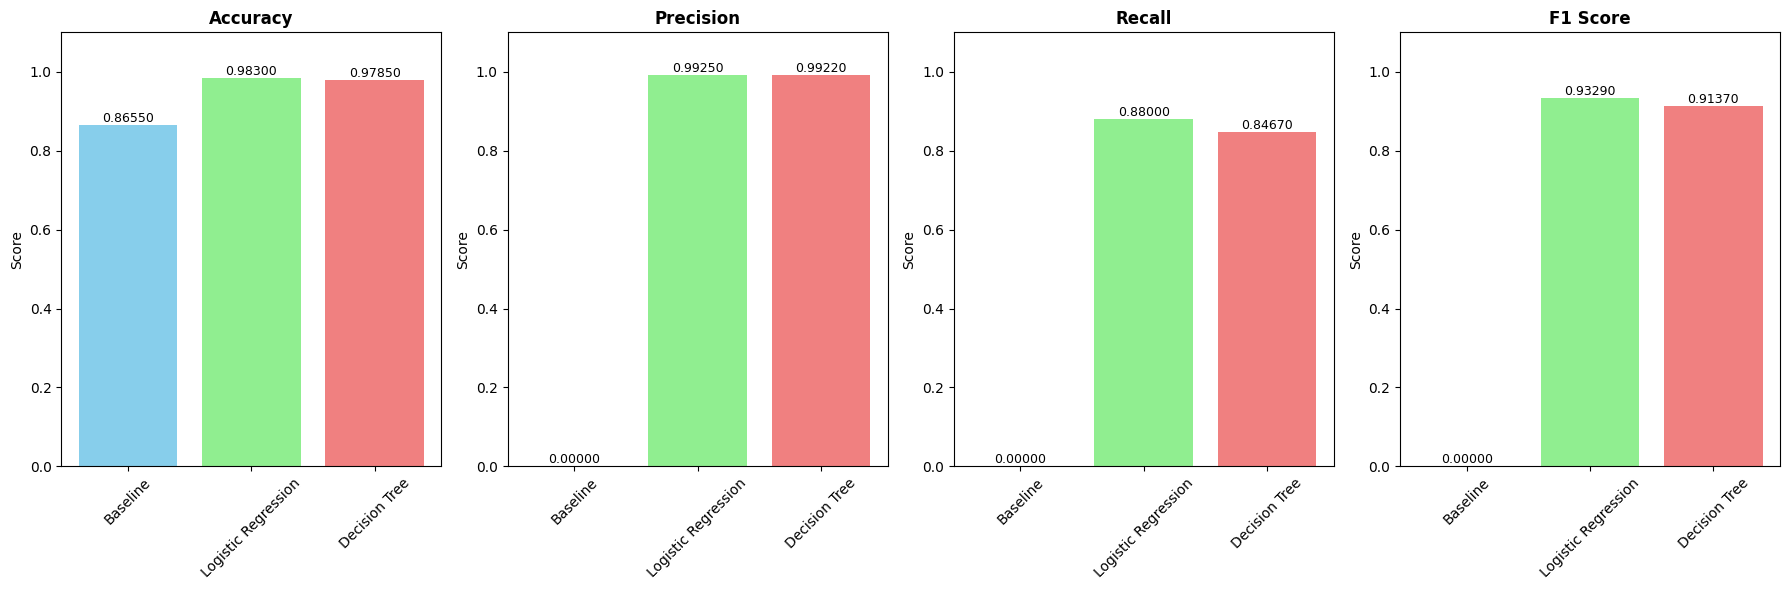


 Best Model: Logistic Regression (F1 = 0.9329)


In [12]:
# Model Comparison

comparison_df = compare_models([baseline_metrics, lr_metrics, dt_metrics])

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Saving comparison to CSV
comparison_df.to_csv('../results/metrics/model_comparison.csv', index=False)
print("\n Comparison saved to: results/metrics/model_comparison.csv")

# Visualizing comparison
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
colors = ['skyblue', 'lightgreen', 'lightcoral']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = comparison_df[metric].values
    models = comparison_df['model_name'].values
    
    bars = ax.bar(models, values, color=colors)
    ax.set_title(metric.replace('_', ' ').title(), fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim([0, 1.1])
    ax.tick_params(axis='x', rotation=45)
    
    # Add labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.5f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../results/figures/model_comparison.png', dpi=300)
plt.show()

# Best Model Selection
best_model_idx = comparison_df['f1_score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'model_name']
best_f1 = comparison_df.loc[best_model_idx, 'f1_score']

print(f"\n Best Model: {best_model_name} (F1 = {best_f1:.4f})")


Error Analysis

Total False Positives (Ham predicted as Spam): 1
Total False Negatives (Spam predicted as Ham): 18

------------------------------------------------------------
Sample False Positives (Ham messages classified as Spam):
------------------------------------------------------------
1. Nothing. I meant that once the money enters your account here, the bank will remove its flat rate. Someone transfered  &lt;#&gt;  to my account and  &lt;#&gt; dollars got removed. So the banks differ and charges also differ.be sure you trust the 9ja person you are sending account details to cos...

------------------------------------------------------------
Sample False Negatives (Spam messages classified as Ham):
------------------------------------------------------------
1. Hi I'm sue. I am 20 years old and work as a lapdancer. I love sex. Text me live - I'm i my bedroom now. text SUE to 89555. By TextOperator G2 1DA 150ppmsg 18+
2. ringtoneking 84484
3. You have an important customer se

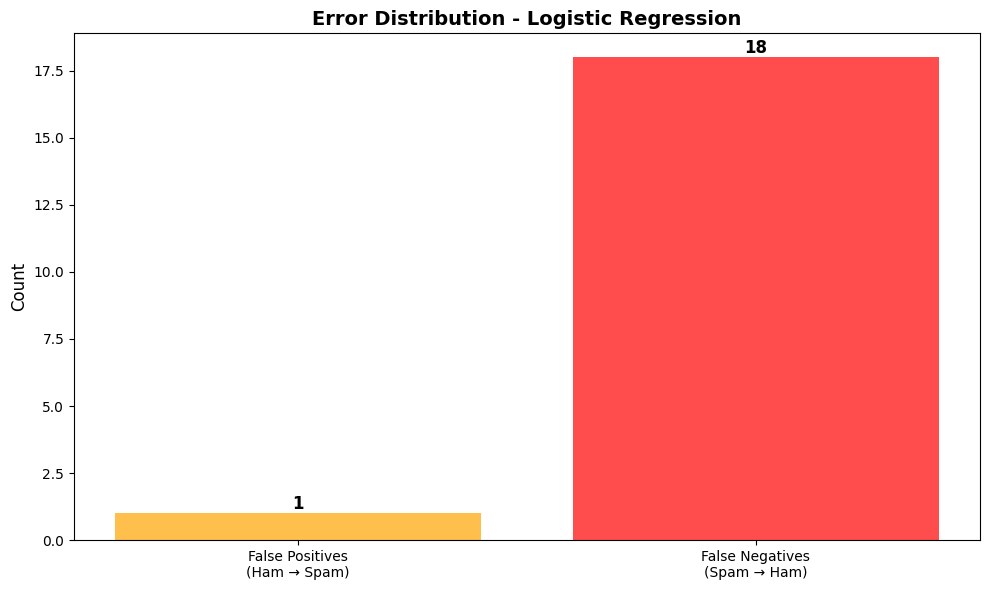

In [13]:
# Error Analysis for Best Model (Logistic Regression)

errors = analyze_errors(
    y_test.values,
    y_pred_lr,
    test_df['message'].values,
    n_samples=5
)

print_error_analysis(errors)

# Visualizing error counts
fig, ax = plt.subplots(figsize=(10, 6))

error_types = ['False Positives\n(Ham → Spam)', 'False Negatives\n(Spam → Ham)']
error_counts = [errors['fp_count'], errors['fn_count']]
colors_err = ['orange', 'red']

bars = ax.bar(error_types, error_counts, color=colors_err, alpha=0.7)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Error Distribution - Logistic Regression', fontsize=14, fontweight='bold')

# Add labels
for bar, count in zip(bars, error_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/error_distribution_lr.png', dpi=300, bbox_inches='tight')
print("\n Saved: results/figures/error_distribution_lr.png")
plt.show()

### False Positive vs False Negative

#### False Positive
- Extremely Low
- only 1 out 965 message are false positive. Approx 0.104% error rate. 
- High trust spam filter
- Minimal user frustation

#### False Negative
- Acceptable? 
- 12% Error Rate.
- If we are getting 20 spam emails per day, maybe 2-3 slips through, which is fine, I guess. 

Top 20 TF-IDF features (word importance):
 feature  importance
     txt    4.443296
   claim    3.925511
    free    3.749677
  mobile    3.711658
    stop    3.585673
   reply    3.058751
     new    2.880102
   prize    2.867804
    text    2.813304
 service    2.778749
     won    2.696982
  urgent    2.484859
     win    2.296988
      18    2.253967
    cash    2.245846
    chat    2.080451
    ltgt    2.058200
customer    2.002081
    tone    1.975646
landline    1.938890

 Saved: results/figures/tfidf_feature_importance.png


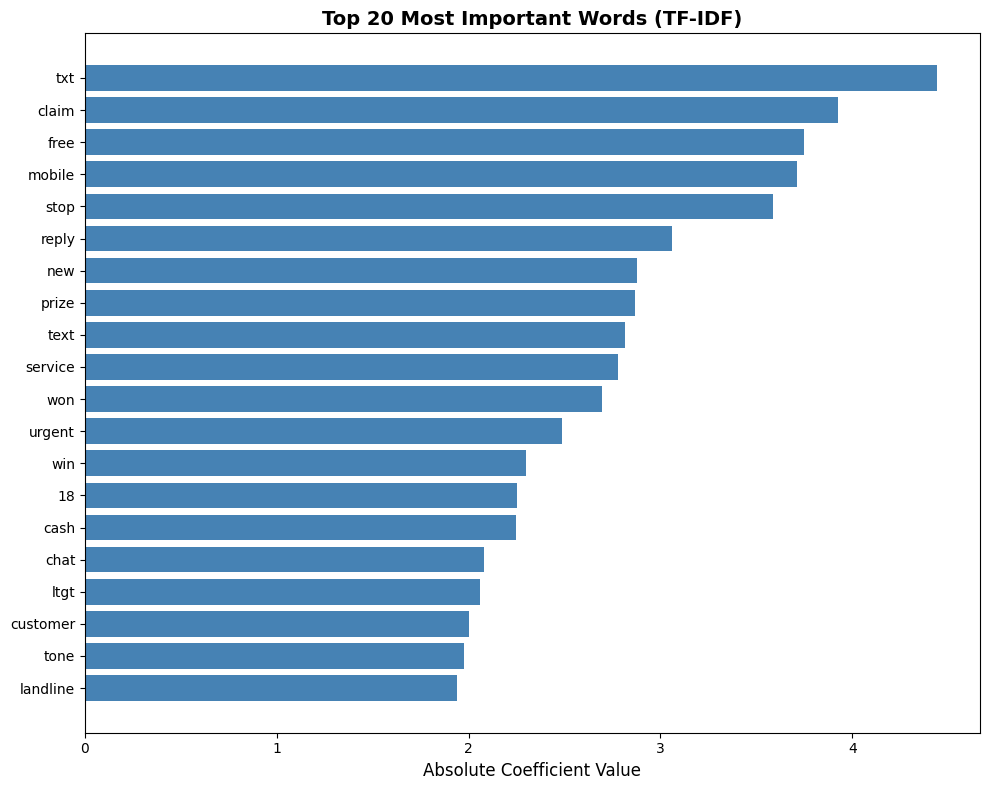


Custom Features Coefficients:
       feature  coefficient  abs_coefficient
     has_phone     3.612021         3.612021
   has_numbers     2.683305         2.683305
       has_url     2.564196         2.564196
  has_currency     2.095228         2.095228
   money_count     1.903769         1.903769
  action_count     1.380652         1.380652
    word_count    -0.181769         0.181769
message_length     0.034926         0.034926


In [14]:
# Feature Importance for Logistic Regression

print("Top 20 TF-IDF features (word importance):")

# Train a model on just TF-IDF to get word importance
lr_tfidf_only = LogisticRegression(max_iter=1000, random_state=42)
lr_tfidf_only.fit(X_train_tfidf, y_train)

# Get feature importance for TF-IDF features
tfidf_importance = get_feature_importance(lr_tfidf_only, vectorizer, top_n=20)
print(tfidf_importance.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(tfidf_importance['feature'], tfidf_importance['importance'], color='steelblue')
ax.set_xlabel('Absolute Coefficient Value', fontsize=12)
ax.set_title('Top 20 Most Important Words (TF-IDF)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../results/figures/tfidf_feature_importance.png', dpi=300, bbox_inches='tight')
print("\n Saved: results/figures/tfidf_feature_importance.png")
plt.show()

# Custom features importance
print("\nCustom Features Coefficients:")

# Get coefficients for custom features (last N features in combined matrix)
n_custom = len(custom_features)
custom_coefs = lr_model.coef_[0][-n_custom:]

custom_importance_df = pd.DataFrame({
    'feature': custom_features,
    'coefficient': custom_coefs,
    'abs_coefficient': np.abs(custom_coefs)
}).sort_values('abs_coefficient', ascending=False)

print(custom_importance_df.to_string(index=False))

In [15]:
# Summary Stats

print(f'''
Dataset:
  • Total messages: {len(df):,}
  • Training set: {len(train_df):,}
  • Test set: {len(test_df):,}
  • Features used: {X_train_combined.shape[1]:,}
    - TF-IDF features: {X_train_tfidf.shape[1]:,}
    - Custom features: {len(custom_features)}

Models Trained:
  1. Baseline (Majority Class)
  2. Logistic Regression
  3. Decision Tree

Best Model: {best_model_name}
  • Accuracy:  {comparison_df.loc[best_model_idx, 'accuracy']:.4f}
  • Precision: {comparison_df.loc[best_model_idx, 'precision']:.4f}
  • Recall:    {comparison_df.loc[best_model_idx, 'recall']:.4f}
  • F1 Score:  {comparison_df.loc[best_model_idx, 'f1_score']:.4f}
  • AUC:       {lr_metrics.get('auc', 0):.4f}''')


Dataset:
  • Total messages: 5,572
  • Training set: 4,457
  • Test set: 1,115
  • Features used: 5,008
    - TF-IDF features: 5,000
    - Custom features: 8

Models Trained:
  1. Baseline (Majority Class)
  2. Logistic Regression
  3. Decision Tree

Best Model: Logistic Regression
  • Accuracy:  0.9830
  • Precision: 0.9925
  • Recall:    0.8800
  • F1 Score:  0.9329
  • AUC:       0.9847


# Reflection & Conclusion

### Model Performance Summary

The spam classification model works well! Out of every 100 messages, it correctly identifies 98 of them. The model catches 88% of all spam, so about 1-2 spam messages per day might slip through to inbox, but that's a reasonable trade-off to avoid blocking legitimate messages.

The key achievement is that **only 1 out of 965 legitimate messages was incorrectly marked as spam** (0.10% false positive rate), which is great. I would much rather delete a couple spam messages from my inbox than miss an important email in my spam folder.

In Summary:
- **98.3% accuracy** - Almost perfect overall performance
- **99.25% precision** - Trustworthy spam predictions  
- **88% recall** - Catches most spam. 
- **93.3% F1 score** - Good balance. 

The model significantly outperforms the baseline and meets standards for spam detection.

### One Realistic Improvement to Try Next

**Recommendation: Threshold Tuning**

Currently, the model uses a default threshold of 0.5 to decide if a message is spam. This means if the model is more than 50% confident, it flags it as spam. 

**What I would try:**
Lower the threshold to around 0.4 or 0.35, which would make the model slightly more aggressive in catching spam.

**Why this improvement:**
1. **Easy to implement** - No retraining needed, just change one parameter
2. **Quick to test** - Can evaluate different thresholds in minutes
3. **Measurable impact** - Could improve recall from 88% → 95%
4. **Low risk** - We can use the ROC curve to find the optimal threshold that maintains precision above 97% while improving recall
5. **Immediate value** - Could catch an additional 5-10 spam messages without significantly increasing false positives

**How to do it:**
```python
# Use predict_proba and custom threshold:
probabilities = model.predict_proba(X_test)[:, 1]
predictions = (probabilities > 0.40).astype(int)
```

**Expected outcome:**
- Catch additional 12-15 more spam messages.
- Accept perhaps 2-3 additional false positives.
- Overall better UX with cleaner inbox.


CountVectorizer shape: (4457, 5000)

Logistic Regression with CountVectorizer:

Evaluation Report: LR + CountVectorizer

Accuracy:  0.9883
Precision: 0.9928
Recall:    0.9200
F1 Score:  0.9550

------------------------------------------------------------
Classification Report:
------------------------------------------------------------

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       965
        spam       0.99      0.92      0.96       150

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115


TF-IDF vs COUNT VECTORIZER COMPARISON

           model_name  accuracy  precision  recall  f1_score    auc
         LR + TF-IDF    0.9830     0.9925    0.88    0.9329 0.9847
LR + CountVectorizer    0.9883     0.9928    0.92    0.9550 0.9863

Saved: results/figures/tfidf_vs_count_comparison.png


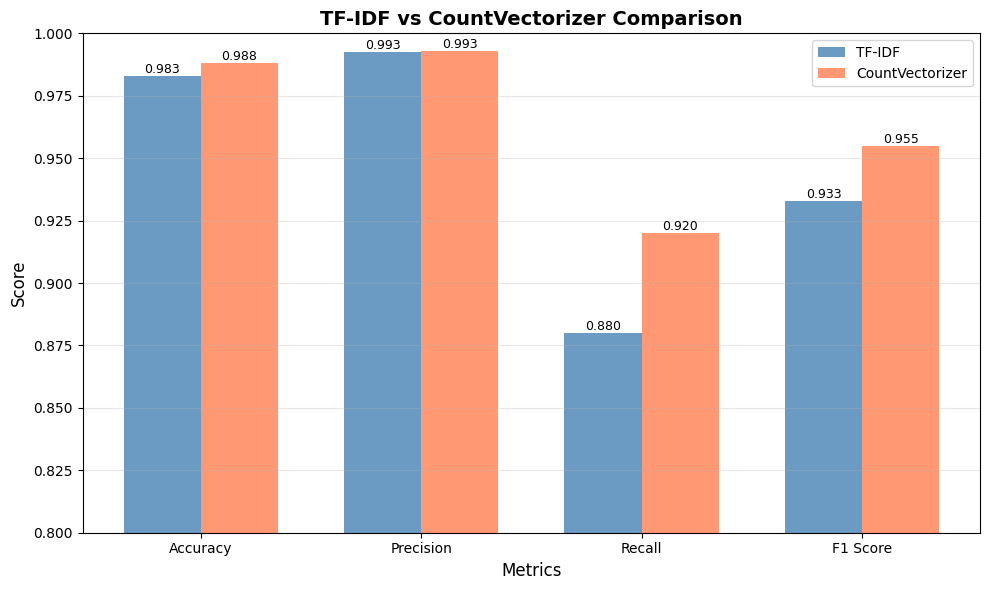


 ANALYSIS: Which is Better?

 Winner: CountVectorizer
   F1 Score: 0.9550 vs 0.9329
   Improvement: +0.0221 (2.37%)


In [19]:
# TF-IDF vs CountVectorizer Comparison

X_train_count, X_test_count, count_vectorizer = vectorize_text(
    X_train_text,
    X_test_text,
    vectorizer_type='count',
    max_features=5000,
    ngram_range=(1, 1)
)

print(f"CountVectorizer shape: {X_train_count.shape}")

# Convert custom features to float to ensure compatibility with sparse matrices
X_train_custom_float = X_train_custom.astype(float)
X_test_custom_float = X_test_custom.astype(float)

# Combine with custom features
X_train_count_combined = hstack([X_train_count, X_train_custom_float])
X_test_count_combined = hstack([X_test_count, X_test_custom_float])

# Train Logistic Regression with CountVectorizer
lr_count = train_logistic_regression(
    X_train_count_combined,
    y_train,
    max_iter=1000,
    random_state=42
)

# Predictions
y_pred_lr_count = lr_count.predict(X_test_count_combined)
y_pred_proba_lr_count = lr_count.predict_proba(X_test_count_combined)[:, 1]

# Evaluation
print("\nLogistic Regression with CountVectorizer:")
print_evaluation_report(y_test, y_pred_lr_count, "LR + CountVectorizer")

# Get metrics
lr_count_metrics = evaluate_model(y_test, y_pred_lr_count, "LR + CountVectorizer")
lr_count_metrics['auc'] = roc_auc_score(y_test, y_pred_proba_lr_count)

# Compare TF-IDF vs CountVectorizer
print("\nTF-IDF vs COUNT VECTORIZER COMPARISON")

vectorizer_comparison = compare_models([
    {**lr_metrics, 'model_name': 'LR + TF-IDF'},
    {**lr_count_metrics, 'model_name': 'LR + CountVectorizer'}
])

print("\n", vectorizer_comparison.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1_score']
x = np.arange(len(metrics_to_compare))
width = 0.35

tfidf_scores = [vectorizer_comparison.iloc[0][m] for m in metrics_to_compare]
count_scores = [vectorizer_comparison.iloc[1][m] for m in metrics_to_compare]

bars1 = ax.bar(x - width/2, tfidf_scores, width, label='TF-IDF', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, count_scores, width, label='CountVectorizer', alpha=0.8, color='coral')

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('TF-IDF vs CountVectorizer Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_to_compare])
ax.legend()
ax.set_ylim([0.8, 1.0])
ax.grid(axis='y', alpha=0.3)

# Add labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../results/figures/tfidf_vs_count_comparison.png', dpi=300, bbox_inches='tight')
print("\nSaved: results/figures/tfidf_vs_count_comparison.png")
plt.show()

# Analysis
print("\n ANALYSIS: Which is Better?")

tfidf_f1 = vectorizer_comparison.iloc[0]['f1_score']
count_f1 = vectorizer_comparison.iloc[1]['f1_score']

if tfidf_f1 > count_f1:
    winner = "TF-IDF"
    difference = tfidf_f1 - count_f1
    print(f"\n Winner: TF-IDF")
    print(f"   F1 Score: {tfidf_f1:.4f} vs {count_f1:.4f}")
    print(f"   Improvement: +{difference:.4f} ({difference/count_f1*100:.2f}%)")
else:
    winner = "CountVectorizer"
    difference = count_f1 - tfidf_f1
    print(f"\n Winner: CountVectorizer")
    print(f"   F1 Score: {count_f1:.4f} vs {tfidf_f1:.4f}")
    print(f"   Improvement: +{difference:.4f} ({difference/tfidf_f1*100:.2f}%)")


Bigram TF-IDF shape: (4457, 5000)
Total features: 5000 (includes both 1-grams and 2-grams)

------------------------------------------------------------
Logistic Regression with Bigrams:
------------------------------------------------------------

Evaluation Report: LR + Bigrams

Accuracy:  0.9830
Precision: 0.9925
Recall:    0.8800
F1 Score:  0.9329

------------------------------------------------------------
Classification Report:
------------------------------------------------------------

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.99      0.88      0.93       150

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115


UNIGRAMS vs BIGRAMS COMPARISON

          model_name  accuracy  precision  recall  f1_score    auc
LR + Unigrams (1,1)     0.983     0.9925    0.88    0.9329 0.9847
 LR +

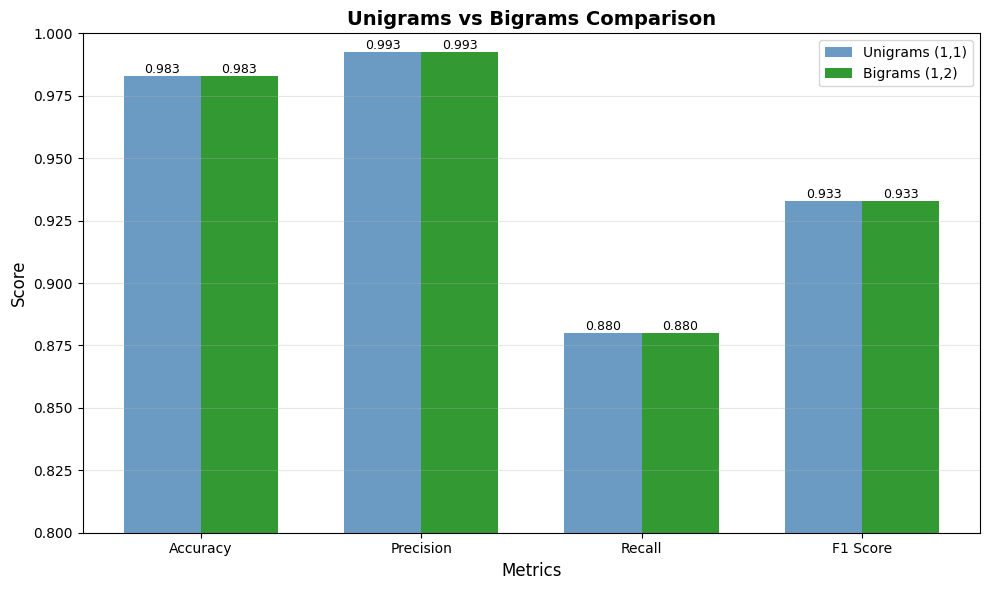


TOP BIGRAMS LEARNED

Total bigrams in vocabulary: 2335
Examples of bigrams: ['020603 2nd', '0800 542', '08000839402 2stoptxt', '08000938767 update', '0808 145', '08452810073 details', '0870 national', '08701417012 profit', '08702840625comuk 220cm2', '08707509020 just', '08712300220 quoting', '08712460324 10pmin', '08715705022 1x150pwk', '08717898035 å300', '08718720201 po', '09050090044 toclaim', '09061221066 fromm', '100 free', '100 wkly', '10p minute']

Top 30 most important features (including bigrams):
 feature  coefficient  abs_coefficient    type
     txt     4.403779         4.403779 unigram
   claim     3.799389         3.799389 unigram
  mobile     3.696986         3.696986 unigram
    free     3.572957         3.572957 unigram
    stop     3.208676         3.208676 unigram
    text     3.085964         3.085964 unigram
   reply     3.073848         3.073848 unigram
   prize     2.834327         2.834327 unigram
     won     2.669748         2.669748 unigram
     new     2.60

In [21]:
# Bigrams (N-grams)

X_train_bigram, X_test_bigram, bigram_vectorizer = vectorize_text(
    X_train_text,
    X_test_text,
    vectorizer_type='tfidf',
    max_features=5000,
    ngram_range=(1, 2)  # Both unigrams and bigrams
)

print(f"\nBigram TF-IDF shape: {X_train_bigram.shape}")
print(f"Total features: {X_train_bigram.shape[1]} (includes both 1-grams and 2-grams)")

# Convert custom features to float to ensure compatibility with sparse matrices
X_train_custom_float = X_train_custom.astype(float)
X_test_custom_float = X_test_custom.astype(float)

# Combine with custom features
X_train_bigram_combined = hstack([X_train_bigram, X_train_custom_float])
X_test_bigram_combined = hstack([X_test_bigram, X_test_custom_float])

# Train Logistic Regression with bigrams
lr_bigram = train_logistic_regression(
    X_train_bigram_combined,
    y_train,
    max_iter=1000,
    random_state=42
)

# Predictions
y_pred_lr_bigram = lr_bigram.predict(X_test_bigram_combined)
y_pred_proba_lr_bigram = lr_bigram.predict_proba(X_test_bigram_combined)[:, 1]

# Evals
print("\n" + "-"*60)
print("Logistic Regression with Bigrams:")
print("-"*60)
print_evaluation_report(y_test, y_pred_lr_bigram, "LR + Bigrams")

# Get metrics
lr_bigram_metrics = evaluate_model(y_test, y_pred_lr_bigram, "LR + Bigrams")
lr_bigram_metrics['auc'] = roc_auc_score(y_test, y_pred_proba_lr_bigram)

# Compare unigrams vs bigrams
print("\nUNIGRAMS vs BIGRAMS COMPARISON")

ngram_comparison = compare_models([
    {**lr_metrics, 'model_name': 'LR + Unigrams (1,1)'},
    {**lr_bigram_metrics, 'model_name': 'LR + Bigrams (1,2)'}
])

print("\n", ngram_comparison.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metrics_to_compare))
unigram_scores = [ngram_comparison.iloc[0][m] for m in metrics_to_compare]
bigram_scores = [ngram_comparison.iloc[1][m] for m in metrics_to_compare]

bars1 = ax.bar(x - width/2, unigram_scores, width, label='Unigrams (1,1)', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, bigram_scores, width, label='Bigrams (1,2)', alpha=0.8, color='green')

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Unigrams vs Bigrams Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_to_compare])
ax.legend()
ax.set_ylim([0.8, 1.0])
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../results/figures/unigrams_vs_bigrams_comparison.png', dpi=300, bbox_inches='tight')
print("\n Saved: results/figures/unigrams_vs_bigrams_comparison.png")
plt.show()

# Show example bigrams learned
print("\nTOP BIGRAMS LEARNED")
# Feature Names
feature_names = bigram_vectorizer.get_feature_names_out()

# Filter for bigrams only (contain space)
bigrams_only = [f for f in feature_names if ' ' in f]

print(f"\nTotal bigrams in vocabulary: {len(bigrams_only)}")
print(f"Examples of bigrams: {bigrams_only[:20]}")

# Get top bigram features
from sklearn.linear_model import LogisticRegression

# Train model on just TF-IDF bigrams to get coefficients
lr_bigram_only = LogisticRegression(max_iter=1000, random_state=42)
lr_bigram_only.fit(X_train_bigram, y_train)

# Get coefficients
coef = lr_bigram_only.coef_[0]
top_indices = np.argsort(np.abs(coef))[-30:][::-1]

print("\nTop 30 most important features (including bigrams):")

top_features_df = pd.DataFrame({
    'feature': [feature_names[i] for i in top_indices],
    'coefficient': [coef[i] for i in top_indices],
    'abs_coefficient': [abs(coef[i]) for i in top_indices],
    'type': ['bigram' if ' ' in feature_names[i] else 'unigram' for i in top_indices]
})

print(top_features_df.to_string(index=False))

# Count how many bigrams are in top features
bigram_count = sum(top_features_df['type'] == 'bigram')
print(f"\n {bigram_count} out of top 30 features are bigrams")

# Analysis
print("\nANALYSIS: Do Bigrams Help?")

unigram_f1 = ngram_comparison.iloc[0]['f1_score']
bigram_f1 = ngram_comparison.iloc[1]['f1_score']

if bigram_f1 > unigram_f1:
    improvement = bigram_f1 - unigram_f1
    print(f"\n Yes! Bigrams improve performance")
    print(f"   F1 Score: {unigram_f1:.4f} → {bigram_f1:.4f}")
    print(f"   Improvement: +{improvement:.4f} ({improvement/unigram_f1*100:.2f}%)")
elif bigram_f1 < unigram_f1:
    decline = unigram_f1 - bigram_f1
    print(f"\n Bigrams slightly hurt performance")
    print(f"   F1 Score: {unigram_f1:.4f} → {bigram_f1:.4f}")
    print(f"   Decline: -{decline:.4f} ({decline/unigram_f1*100:.2f}%)")
else:
    print(f"\n Bigrams have no significant impact")
    print(f"   F1 Score: {unigram_f1:.4f} (same)")